<a href="https://colab.research.google.com/github/Alfaalputra/Alfaalputra/blob/main/Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/temp.csv

--2020-08-25 20:11:31--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/temp.csv’

/tmp/temp.csv       100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-08-25 20:11:31 (5.46 MB/s) - ‘/tmp/temp.csv’ saved [67921/67921]



In [ ]:
import pandas as pd
data = pd.read_csv('/tmp/temp.csv')
data.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

# Set the date as index of  our data frame
data.set_index('Date', inplace=True)
data.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [ ]:
#Check any empty values
data.isnull().sum()

Temp    0
dtype: int64

In [ ]:
data.describe()
# Check detail of the data, which can help to count our MAE (Mean Absolute Error)
# MAE < 10% (max - min) in our case, the data is the temperature value
# MAE < 10% (26.3 - 0)
# MAE < 2.63

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


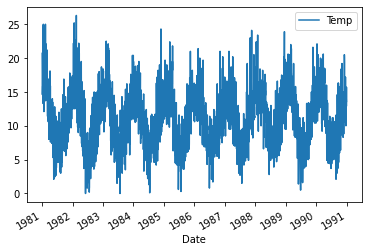

In [ ]:
data.plot()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to plot our data
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.grid(True)

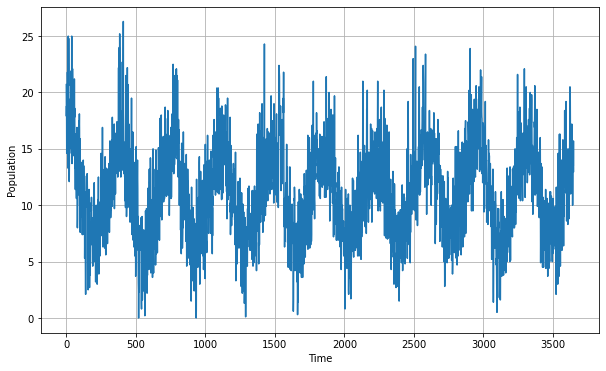

In [ ]:
import csv
index = 0
time_step = []
temp = []

with open('/tmp/temp.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    temp.append(float(row[1]))
    time_step.append(index)
    index = index + 1

series = np.array(temp)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
# Set the hyperparameter
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000
valid_portion = 0.2

# Split our data into training and validation
split_time = int(valid_portion * len(series))
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
# Helper function to create window dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
import tensorflow as tf
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

# Use LearningRateScheduler to find the best learning rate to use
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
21/21 [==============================] - 0s 17ms/step - loss: 15.3643 - mae: 15.8639
Epoch 2/100
21/21 [==============================] - 0s 14ms/step - loss: 14.6031 - mae: 15.1024
Epoch 3/100
21/21 [==============================] - 0s 15ms/step - loss: 13.6276 - mae: 14.1268
Epoch 4/100
21/21 [==============================] - 0s 15ms/step - loss: 12.5350 - mae: 13.0326
Epoch 5/100
21/21 [==============================] - 0s 15ms/step - loss: 11.3488 - mae: 11.8435
Epoch 6/100
21/21 [==============================] - 0s 15ms/step - loss: 10.1295 - mae: 10.6241
Epoch 7/100
21/21 [==============================] - 0s 15ms/step - loss: 8.8972 - mae: 9.3890
Epoch 8/100
21/21 [==============================] - 0s 14ms/step - loss: 7.7139 - mae: 8.2041
Epoch 9/100
21/21 [==============================] - 0s 15ms/step - loss: 6.6214 - mae: 7.1069
Epoch 10/100
21/21 [==============================] - 0s 15ms/step - loss: 5.7427 - mae: 6.2268
Epoch 11/100
21/21 [=================

(1e-08, 0.0001, 0.0, 60.0)

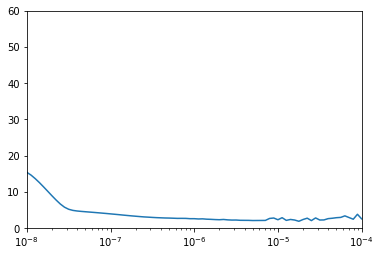

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])
# The best learning rate is around 8x10^-5

In [ ]:
# Retrain our model using our new learning rate for more epoch
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])


optimizer = tf.keras.optimizers.SGD(lr=8e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
21/21 [==============================] - 0s 15ms/step - loss: 20.2454 - mae: 20.7438
Epoch 2/500
21/21 [==============================] - 0s 13ms/step - loss: 7.4185 - mae: 7.9129
Epoch 3/500
21/21 [==============================] - 0s 14ms/step - loss: 3.4321 - mae: 3.9074
Epoch 4/500
21/21 [==============================] - 0s 14ms/step - loss: 2.6114 - mae: 3.0729
Epoch 5/500
21/21 [==============================] - 0s 14ms/step - loss: 2.8548 - mae: 3.3258
Epoch 6/500
21/21 [==============================] - 0s 14ms/step - loss: 2.9689 - mae: 3.4393
Epoch 7/500
21/21 [==============================] - 0s 14ms/step - loss: 2.4978 - mae: 2.9634
Epoch 8/500
21/21 [==============================] - 0s 14ms/step - loss: 2.3383 - mae: 2.8004
Epoch 9/500
21/21 [==============================] - 0s 14ms/step - loss: 2.1280 - mae: 2.5912
Epoch 10/500
21/21 [==============================] - 0s 14ms/step - loss: 2.2774 - mae: 2.7400
Epoch 11/500
21/21 [===========================

In [ ]:
# Helper function for predicting
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
# Try our model by forecast using our original series
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, 0]

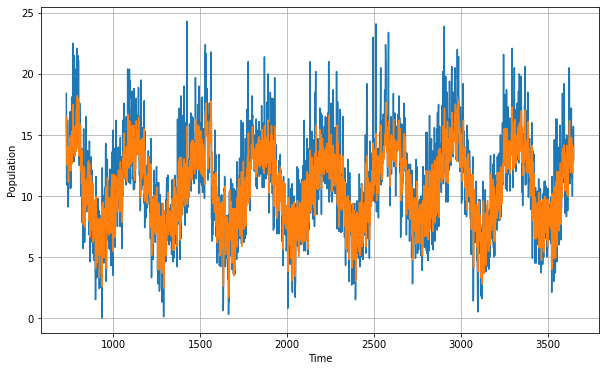

In [ ]:
# Plot our prediction and compare it with the actual data
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
# Count the MAE of our model
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.9143478

<Figure size 432x288 with 0 Axes>

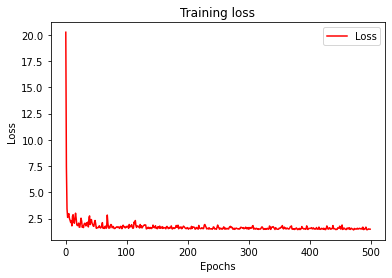

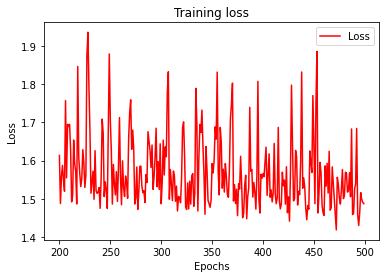

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot our training loss
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()